# Gaussian processes

## Introduction

This notebook introduces the Gaussian process surrogate modelling implementation in `sumomo`.

Begin by ensuring that this notebook directory is on the system path and importing necessary packages including `numpy`. The `sumomo` functionality is made accessible through the `api` instance, whilst utilities such as black box models and plotting functions are imported from the `utils` script. We use the `plot_peaks` function to visualise the underlying black box model used in this notebook for demonstrative purposes, coded in `peaks` and with the functional form shown below.

$$ f(x) = 3(1-x_0)^2 \exp\left(-x_0^2 - (x_1 + 1)^2\right) - 10 \left(\frac{x_0}{5} - x_0^3 - x_1^5\right)\exp\left(-x_0^2 - x_1^2\right) - \frac{1}{3}\exp\left(-(x_0+1)^2 - x_1^2\right) $$

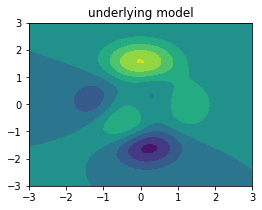

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np

from sumomo import API
from utils import peaks, plot_peaks, plot_gp, func_1d, plot_1d


plot_peaks()

## Sampling

Initialise the sampling strategy with 100 samples bounded in two dimensions between (-3.0, 3.0) with 1 output variable using Latin hypercube sampling. Sample the output data from the peaks function. Split the data into training (70 samples) and testing sets (30 samples). Standardise the data accordingly.

In [2]:
api = API(100, [(-3.0, 3.0), (-3.0, 3.0)], 1, 'lhs')

for i in range(api.x.shape[0]):
    api.y[i] = peaks(api.x[i])

api.split(test_size=0.3)
api.scale()

print(api.y_test_)

[[-0.14504248]
 [ 0.16896283]
 [ 0.67697125]
 [-0.18247192]
 [ 2.48897771]
 [-0.98914992]
 [-0.1826964 ]
 [-0.32382564]
 [ 0.20261962]
 [-0.16524497]
 [-0.1828577 ]
 [-0.12966581]
 [-0.36202337]
 [-0.21937888]
 [ 0.09839848]
 [-0.16242198]
 [-0.19926479]
 [-0.09031972]
 [-0.13774513]
 [-1.39031372]
 [-0.32005467]
 [-0.16177383]
 [-1.33177776]
 [-0.69390403]
 [ 1.4445262 ]
 [-1.84403721]
 [-0.13677538]
 [-0.07420914]
 [ 0.19891351]
 [ 0.00868936]]


## Gaussian process regression

A Gaussian process describes a Gaussian (or Normal) distribution over functions. Similar to how a normal distribution of random variables can be fully defined by a mean and variance, a Gaussian process is specified completely by a mean function, $\mu(x)$, and a covariance function, $k(x, x')$. Specifically, a real process $f(\textbf{x})$ can be represented by a Gaussian process over functions with a joint distribution shown below. Notice here that the mean and covariance of *functions* are written as functions of *inputs*. We write that the real process is asymptotic to the Gaussian process because, as more observations are made, the distribution over functions becomes tighter around the real function.

$$ f(\textbf{x}) \sim \mathcal{N} \left(\mu(\textbf{x}), k(\textbf{x}, \textbf{x}') \right) $$

The covariance function enables users to incorporate expert knowledge into the model, for example favouring smooth, periodic, or noisy functions. In this case, the squared exponential covariance function is used, where $\sigma^2_f$ and $l$ are the postive function variance parameter and characteristic length scale, respectively. The length scale represents the sensitivty of the function, where higher values ensure that even two points far away are correlated resluting in an overall smoothing effect, whilst lower values result in higher frequency function changes. Note that the length scale appears as $l^2$ is the equation as it has been taken outside the squared distance term although it could be written as $ \left|\frac{x_j - x'_j}{l}\right|^2 $. This covariance function can be evaluated between two points $\textbf{x}, \textbf{x}'$ in $m$-dimensional space, such that $x_j, x'_j$ represent coordinates for $j=1, ... m$.

$$ k(\textbf{x}, \textbf{x}') = \sigma^2_f\exp\left( - \sum_{j=1}^m \frac{1}{2l^2} \left|x_j - x'_j\right|^2 \right) $$

The mean function is typically assumed to a constant or equal to zero since modelling the covariances in this way is sufficient to capture the overall model behaviour. Modelling the mean as a constant removes the dependence on the inputs and in the case of mean equal to zero, the Gaussian process prior distrubtion can be written as below. This 0 assumption has the extra validation that since the data is standardised prior to modelling the mean of the data is actually 0.

$$ f(\textbf{x}) \sim \mathcal{N} \left(0, k(\textbf{x}, \textbf{x}') \right) $$

Given a set of training observations $\textbf{f}$ made over training inputs $\textbf{x}$, and a single testing input $\textbf{x}_*$, the joint distribution with the unknown testing output $f_*$ according to the prior is given by below. It is possible to simplify the notation, such that $K$ represents the $n\times n$ covariance matrix between $n$ training samples, $k(\textbf{x}_*$ is the $n$-vector of covariances between the new input and $n$ training samples, and the covariance between the new input and itself $k(\textbf{x}_*, \textbf{x}_*)$ is equal to the process variance $\sigma^2_f$.

$$ \begin{align}
\begin{bmatrix}
\textbf{f}\\
f_*
\end{bmatrix} &  \sim \mathcal{N} \left( \begin{bmatrix} \textbf{0}\\ 0 \end{bmatrix}, \begin{bmatrix}
K(\textbf{x}, \textbf{x}) & \textbf{k}(\textbf{x}, \textbf{x}_*)\\
\textbf{k}(\textbf{x}_*, \textbf{x}) & k(\textbf{x}_*, \textbf{x}_*)
\end{bmatrix} \right) \\
& \sim \mathcal{N} \left( \begin{bmatrix} \textbf{0}\\ 0 \end{bmatrix}, \begin{bmatrix}
K & \textbf{k}_*\\
\textbf{k}^T_* & \sigma^2_f
\end{bmatrix} \right) \end{align}$$

By conditioning this joint distribution prior on the observations,

$$ \begin{bmatrix}
\textbf{x}\\
\textbf{y}
\end{bmatrix} \sim \mathcal{N} \left( \begin{bmatrix} \boldsymbol{\mu}_x\\ \boldsymbol{\mu}_y \end{bmatrix}, \begin{bmatrix}
A & C\\
C^T & B
\end{bmatrix} \right)$$

$$ \textbf{x} | \textbf{y} \sim \mathcal{N} \left( \boldsymbol{\mu}_x + C B^{-1}(\textbf{y} - \boldsymbol{\mu}_y) , A - C B ^{-1} C^T \right) $$

### Predictive function and uncertainty

The testing output can be written as a Gaussian posterior distribution with mean function and variance.

$$ \bar{f_*} = \textbf{k}_*^T K^{-1}\textbf{f} $$

$$ \mathbb{V}\left[{f_*}\right] = \sigma^2_f - \textbf{k}_*^T K^{-1}\textbf{k}_* $$

### Predictions with noisy observations

In the case of noisy observations where $\textbf{y} = \textbf{f} + \epsilon$, this noise can be incorporated into the covariance function by adding an additional variance term to the diagonal.

$$ \text{cov}(\textbf{y}) = K(\textbf{x}, \textbf{x}) + \sigma^2_n I $$
 
The corresponding joint distrubtion between noisy observations and a noisy prediction can be written as.
 
$$ \begin{align}
\begin{bmatrix}
\textbf{y}\\
y_*
\end{bmatrix} \sim \mathcal{N} \left( \begin{bmatrix} \textbf{0}\\ 0 \end{bmatrix}, \begin{bmatrix}
K + \sigma^2_n I & \textbf{k}_*\\
\textbf{k}^T_* & \sigma^2_f + \sigma^2_n
\end{bmatrix} \right) \end{align}$$

The resulting predictive mean function and variance function provide a more generalised version with optional noise.

$$ \bar{y_*} = \textbf{k}_*^T (K + \sigma^2_n I)^{-1}\textbf{y} $$

$$ \mathbb{V}\left[{y_*}\right] = \sigma^2_f + \sigma^2_n - \textbf{k}_*^T (K + \sigma^2_n I)^{-1}\textbf{k}_* $$

### Linear predictor

Since $(K + \sigma^2_n I)^{-1}\textbf{y}$ is only a function of the training data, only $\textbf{k}_*^T$ depends on the new input, so the predictive mean function can be written as the linear predictor.

$$ \bar{y}(\textbf{x}_*) = \sum_i^n \alpha_i k(\textbf{x}_i, \textbf{x}_* ) $$
 
 ### GPR
 
The Sumomo `GPR` class inherits from the `GaussianProcessRegressor` from *scikit-learn*. Specifically, `GPR` is initialised with the an optional `noise` attribute with default value equal to 0. Additionally, `GPR` is initialised with the squared exponential kernel also known as the radial basis function `RBF` kernel from *scikit-learn*, with an initial `length_scale` equal to 1 and `length_scale_bounds` at (0, 100). The `1.0` pre-factor to `RBF` provides a kernel scaling paramter equivalent to $\sigma_f^2$.

`GPR` has a method `fit(x, y)` which calls the method of the same name from `GaussianProcessRegressor` whilst simultaneously saving `x` and `y`, and the optimisation parameters to the class for further use. The fitting is performed by maximum likelihood estimation to minimise the negative log marginal likelihood using *scipy.optimize.minimize*.

Specifically, the `GPR` class method `save_params()` obtains the optimised kernel parameters after fitting, the pre-exponential `constant_value` equivalent to $\sigma_f^2$ and the `length_scale`. In addition, `invK` equivalent to $K^{-1}$ and `alpha` from the linear predictor are saved. Finally, further consolidation is done to save $\alpha_i \sigma_f^2$ as an $n$-vector `beta` where $n$ is the number of training samples and size of $\alpha$.

Predictions are made using `GPR.predict(x)` with optional parameter `return_std` equal to `False` in which case only the predictive mean function is evaluated at the inputs. For `return_std` equal to `True`, the predictive mean is returned along with the standard deviation of the predictions, equivalent to $\sqrt{\mathbb{V}\left[{y_*}\right]}$ Again, the `GaussianProcessRegressor` predict method is called.

Finally, `GPR` contained the `formulation(x, return_std=False)` method with the same function as `predict()` but with *NumPy* formulations equivalent to the *Pyomo* fomrulations implemented later.

```python
class GPR(GaussianProcessRegressor):
    def __init__(self, noise=0.0):
        super().__init__(kernel=self.kernel(), alpha=noise)
        self.name = 'GPR'
        self.x_train = None
        self.length_scale = None
        self.constant_value = None
        self.inv_K = None
        self.noise = noise
    
    def kernel(self):
        kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(0, 1e2))
        return kernel

    def fit(self, x, y):
        self.x_train = x
        super().fit(x, y)
        self.save_params()
    
    def save_params(self):
        params = self.kernel_.get_params()
        self.constant_value = params['k1__constant_value']
        self.length_scale = params['k2__length_scale']
        self.alpha = self.alpha_.ravel()
        K = self.kernel_(self.x_train, self.x_train) + np.eye(self.x_train.shape[0]) * self.noise
        self.inv_K = inv(K)
    
    def predict(self, x, return_std=False):
        if return_std:
            return super().predict(x, return_std=True)
        else:
            return super().predict(x, return_std=False)

    def formulation(self, x, return_std=False):
        n = self.x_train.shape[0]
        m = self.x_train.shape[1]
        sq_exp = np.exp(
            -sum(0.5 / self.length_scale ** 2 * (x[:, j] - self.x_train[:, j]) ** 2 for j in range(m))
            )
        k_s = self.constant_value * sq_exp
        pred = sum(k_s[i] * self.alpha[i] for i in range(n))
        if return_std:
            k_K_k = sum(k_s[i] * sum(self.inv_K[i, j] * k_s[j] for j in range(n)) for i in range(n))
            var = self.constant_value + self.noise - k_K_k
            std = np.sqrt(var)
            return pred, std
        else:
            return pred
```


* varying $l$
* varying $\sigma^2_f$
* varying $\sigma^2_n$
* different kernel functions
* fitting or parameter optimisation
* *NumPy* formulation

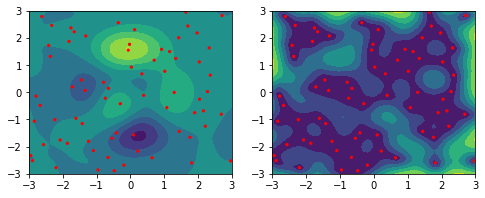

In [3]:
api.init_regressor('gp', noise=0.0)

with np.errstate(divide='ignore'):
    api.regressor.fit(api.x_train_, api.y_train_)

plot_gp(api, show_samples=True)

In [4]:
api.test('rmse')

0.08689476522983798

In [5]:
print(api.regressor.length_scale)

0.3938542012429478


## Gaussian process classification

Implemented in *NumPy*...

In [6]:
from sklearn.datasets import make_moons
from sumomo.gp import GPC


X_train, t = make_moons(50, noise=0.3)
t = t.reshape(-1, 1)

gpc = GPC()
gpc.fit(X_train, t)
print(gpc.l, gpc.sigma_f ** 2)

0.9107777939137367 9.984765543079734


[[0.50001861]
 [0.50003687]
 [0.5000663 ]
 ...
 [0.50332169]
 [0.5034461 ]
 [0.5033594 ]]
[[0.50001861]
 [0.50003687]
 [0.5000663 ]
 ...
 [0.50332169]
 [0.5034461 ]
 [0.5033594 ]]


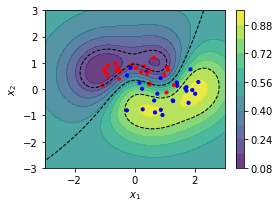

In [7]:
x1, x2 = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1grid, x2grid = np.meshgrid(x1, x2)
X = np.c_[x1grid.ravel(), x2grid.ravel()]

prediction, std = gpc.predict(X, return_std=True)
print(prediction)
formulation_pred = np.zeros_like(prediction)
for i in range(len(formulation_pred)):
    formulation_pred[i] = gpc.formulation(X[i])
print(formulation_pred)
prediction = prediction.reshape(x1grid.shape)
std = std.reshape(x1grid.shape)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4, 3))
ax1 = fig.add_subplot(111)
c1 = ax1.contourf(x1, x2, prediction, levels=12, alpha=0.8)
ax1.scatter(X_train[:, 0], X_train[:, 1], s=10, c=t, cmap='bwr_r')
ax1.contour(x1, x2, prediction, levels=[0.2, 0.5, 0.8], linestyles='dashed', colors='k', linewidths=1)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
fig.colorbar(c1, ax=ax1)
plt.tight_layout()

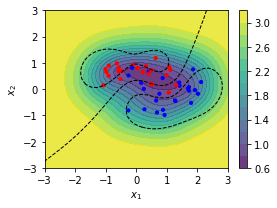

In [8]:
fig = plt.figure(figsize=(4, 3))
ax1 = fig.add_subplot(111)
c1 = ax1.contourf(x1, x2, std, levels=12, alpha=0.8)
ax1.scatter(X_train[:, 0], X_train[:, 1], s=10, c=t, cmap='bwr_r')
ax1.contour(x1, x2, prediction, levels=[0.2, 0.5, 0.8], linestyles='dashed', colors='k', linewidths=1)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
fig.colorbar(c1, ax=ax1)
plt.tight_layout()

In [9]:
space = [(-6.0, 6.0)]
n_samples = 11

from sumomo.gp import GPR

api = API(n_samples, space)

y_train = func_1d(api.x)

t = np.ones_like(api.x)
t[api.x < -4] = 0
t[api.x > 2] = 0
t = t.reshape(-1, 1)

gpr = GPR()
gpr.fit(api.x[t.ravel()==1, :], y_train[t.ravel()==1])

gpc = GPC()
gpc.fit(api.x, t)

/Users/alexdurkin/miniconda3/envs/phd-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


In [10]:
x_new = np.arange(-8, 8, 0.01).reshape(-1, 1)
pred, std = gpr.predict(x_new, return_std=True)
un = 1.96 * std
f, s = gpc.predict(x_new, return_std=True)

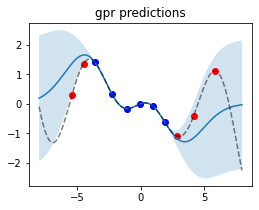

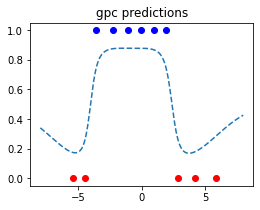

In [11]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(x_new, pred)

ax.plot(x_new, func_1d(x_new), ls='--', alpha=0.5, c='k')
ax.title.set_text('gpr predictions')
ax.fill_between(x_new.ravel(), pred.ravel() + un.ravel(), pred.ravel() - un.ravel(), alpha=0.2)
ax.scatter(api.x[t.ravel()==1, :], y_train[t.ravel()==1], c='b')
ax.scatter(api.x[t.ravel()==0, :], y_train[t.ravel()==0], c='r')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(x_new, f, ls='--')
ax.scatter(api.x[t==1], t[t==1], c='b')
ax.scatter(api.x[t==0], t[t==0], c='r')
ax.title.set_text('gpc predictions')
plt.show()

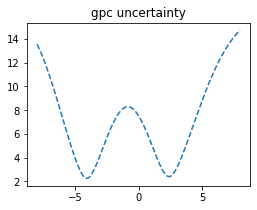

In [12]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(x_new, s, ls='--')
ax.title.set_text('gpc uncertainty')
plt.show()